In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/MachineLearning/RNN')
%pwd

'/content/drive/MyDrive/Colab Notebooks/MachineLearning/RNN'

# Character level language model - Dinosaurus land

** This problem comes from Andrew Ng's coursera course. Instead of using their Keras-based solution, we will try to solve this problem based on PyTorch.**

Imagine that leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go beserk, so choose wisely!  

Luckily you have learned some deep learning and you will use it to save the day. To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. 


By completing this assignment you will learn:

- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network




In [ ]:
import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

## Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [ ]:
def split_to_names(fname):
    EOS = "<EOS>"
    data = []
        
    ## 파일을 열어서 모두 소문자로 바꿈
    with open(fname) as file:
        text = file.read().lower()
            
    names = text.splitlines()
    for i, name in enumerate(names):
        # Split names to chars and append the End of Sequence (EOS) Token
        ch_list = list(name) + [EOS] ## EOS 끝마다 붙여줌
        data.append(ch_list)
    return data

dino_list_in_char = split_to_names("dinos.txt")

## 어떤 데이터셋을 가지고 있는지 찍어보기
print(dino_list_in_char[0])
print(dino_list_in_char[1])
## 리스트를 여러개 가지고 있는 리스트 셋

['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '<EOS>']
['a', 'a', 'r', 'd', 'o', 'n', 'y', 'x', '<EOS>']


The characters are a-z (26 characters) plus the "\n" (or newline character), which in this assignment plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture, only here it indicates the end of the dinosaur name rather than the end of a sentence. 
In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, `char_to_ix` and `ix_to_char` are the python dictionaries. 

In [ ]:
char_vocab = ["<EOS>"] + sorted([ch for ch in string.ascii_lowercase])

char_to_ix = {ch:i for i,ch in enumerate(char_vocab)}
ix_to_char = {i:ch for ch,i in char_to_ix.items()}

print(char_to_ix)
print(ix_to_char)

## mapping

{'<EOS>': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '<EOS>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


## Data Loading






In [ ]:
def keys_to_values(keys, _map, default):
    return [_map.get(key, default) for key in keys]

## 리스트의 리스트를 데이터셋으로 만들어주기 위해 3가지 함수 정의
## 생성자, 길이, 인덱스를 주면 해당하는 데이터를 텐서로 돌려주는 함수
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, _map):
        self.data_as_int = []
        
        # Convert characters to integers
        for seq_as_str in data_as_str:
            seq_as_int = keys_to_values(seq_as_str, _map, random.choice(list(_map)))
            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]
        
        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)


In [ ]:
dataset = Dataset(dino_list_in_char, char_to_ix)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

xx, yy = dataset.__getitem__(0)

print("x from dataset:", xx)
print("y from dataset:", yy)

## 하나의 공룡 이름에서 x와 y를 가져왔음
## y는 맨 왼쪽의 1이 탈락된 모습을 볼 수 있음(Launguage model)

x from dataset: tensor([ 1,  1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19])
y from dataset: tensor([ 1,  3,  8,  5, 14, 15, 19,  1, 21, 18, 21, 19,  0])


In [ ]:
## 위 각각의 index를 8개의 elements를 가지는 벡터로 표현
## Embedding 하는 item 숫자가 27개, Embedding dimension을 8로 하겠다.
t_embedding = nn.Embedding(num_embeddings=27, embedding_dim = 8)
t_embed = t_embedding(xx)
print(t_embed)


tensor([[ 1.4956e+00, -5.9332e-01,  1.0907e+00,  1.9197e+00,  5.7344e-01,
          6.8328e-01,  7.4445e-01,  3.5668e-01],
        [ 1.4956e+00, -5.9332e-01,  1.0907e+00,  1.9197e+00,  5.7344e-01,
          6.8328e-01,  7.4445e-01,  3.5668e-01],
        [ 2.4455e+00,  1.7260e-02,  1.3640e+00, -2.0457e+00,  2.0030e+00,
         -6.7758e-01, -5.2432e-01, -1.9478e-01],
        [ 6.3873e-01, -1.6723e+00,  8.6937e-01, -1.7642e-01, -3.7685e-02,
          1.5148e-01, -1.9051e+00,  1.6857e-01],
        [-1.4244e+00, -1.1405e+00, -8.2384e-01,  1.9559e-01,  3.7524e-01,
         -1.9598e+00,  7.5104e-01,  9.4727e-01],
        [-6.3129e-01, -1.9875e-03,  1.2487e+00,  1.6105e-01, -9.0381e-01,
          9.3913e-01, -8.6286e-02,  5.9233e-01],
        [ 1.6968e+00, -9.8051e-01, -1.4172e+00, -9.3632e-01,  1.1405e-01,
         -1.1808e+00,  3.6471e-01,  8.2431e-01],
        [-1.5723e+00,  2.0064e+00, -3.9730e-01,  1.3988e+00,  1.0129e+00,
          2.4048e-01,  1.4540e+00,  1.2826e-01],
        [ 1.4956

## Model

Build a neural network

In [ ]:
class Model(nn.Module):
    def __init__(self, _map, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        super(Model, self).__init__()
        
        self.vocab_size  = len(_map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim)
        
        self.lstm = nn.LSTM(
            input_size =self.emb_dim,
            hidden_size=self.hidden_size,
            num_layers =self.n_layers,
            batch_first=True)  # if True, input and output tensors are in (batch, seq, feature)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)
        
    def forward(self, x, init_state):

        # x : (batch, seq)
        # init_state = (h, c) # tuple
        # h, c : (layer, batch, hidden_size)
        n_b, n_s = x.shape
        
        # embed = (batch, seq, embed)
        embed = self.embedding(x)

        # lstm's input : embed, (h_0, c_0)
        # lstm's output: y, (h_n, c_n)
        #                y : (batch, seq, hidden_size)
        # *** y_n == h_n
        # refer to https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # lstm
        yhat, final_state = self.lstm(embed, init_state)
        
        # dropout
        ## yhat을 그냥 쓰지 않고 dropout해서 사용
        yhat = self.dropout(yhat)
        
        # fully connected layer
        ## 차원을 줄여줌
        out = self.fc(yhat)
        
        return out, final_state
    
    def init_state(self, b_size=1):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

model = Model(char_to_ix, 64, 8, n_layers=1, dropout_p=0.2)

## Training

In [ ]:
def train(model, data, num_iter, criterion, clip=0.25, lr=0.001, print_every=50):
    model.train()
    
    costs = []
    running_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=lr)

    curr_iter = 0
    while curr_iter<num_iter:
        for x, y in data:
            optimizer.zero_grad()
            
            # Initialise model's state and perform forward-prop
            init_state = model.init_state(b_size=x.shape[0])
            
            # forward propagation
            ## 내가 만든 class를 어떻게 사용할지
            out, state = model(x, init_state) 

            # Calculate loss
            # criterion's input : (batch, class) --> out (1, seq, class)
            ## (batch, class) :: output of softmax <- 2개 이상의 클래스 구현
            ## LSTM으로 넘어오면 shape이 하나 더 붙는다. 연속으로 나오는 output을 비교해주기 위한 sequence
            # criterion's target : (batch)  --> y (1, seq)

            ## input의 (batch, class)와 정답지/target의 (batch, seq)를 비교해주기 위해서는
            ## class와 sequence number 자리를 바꿔주어야 한다.

            loss = criterion(out.transpose(1, 2), y)
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            
            ## gredient 얼마 이상 넘지 못하도록 제한
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            curr_iter += 1
            if print_every and (curr_iter%print_every)==0:
                print("Iteration: {:{}}/{}, Loss: {:8.4f}".format(
                    curr_iter, int(math.log(num_iter, 10))+2, num_iter,
                    running_loss/float(print_every)))
                running_loss = 0
                
            if curr_iter>=num_iter:
                break
    return model, costs


criterion = nn.CrossEntropyLoss()
model, costs = train( model, dataloader, 50000 , criterion, clip=0.25, lr=1e-3, print_every=1000)

Iteration:   1000/50000, Loss:   2.3445
Iteration:   2000/50000, Loss:   1.9537
Iteration:   3000/50000, Loss:   1.8356
Iteration:   4000/50000, Loss:   1.7774
Iteration:   5000/50000, Loss:   1.7402
Iteration:   6000/50000, Loss:   1.6866
Iteration:   7000/50000, Loss:   1.6478
Iteration:   8000/50000, Loss:   1.6412
Iteration:   9000/50000, Loss:   1.6357
Iteration:  10000/50000, Loss:   1.5827
Iteration:  11000/50000, Loss:   1.5864
Iteration:  12000/50000, Loss:   1.5372
Iteration:  13000/50000, Loss:   1.5282
Iteration:  14000/50000, Loss:   1.5453
Iteration:  15000/50000, Loss:   1.5181
Iteration:  16000/50000, Loss:   1.4614
Iteration:  17000/50000, Loss:   1.5059
Iteration:  18000/50000, Loss:   1.4566
Iteration:  19000/50000, Loss:   1.4719
Iteration:  20000/50000, Loss:   1.4419
Iteration:  21000/50000, Loss:   1.4163
Iteration:  22000/50000, Loss:   1.4401
Iteration:  23000/50000, Loss:   1.4037
Iteration:  24000/50000, Loss:   1.3745
Iteration:  25000/50000, Loss:   1.3944


## Plotting

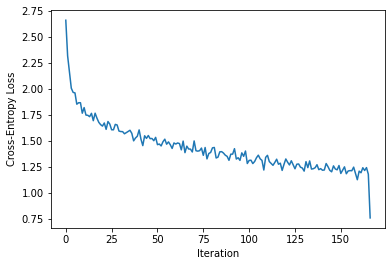

In [ ]:
cum = 300
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.plot([sum(costs[i:i+cum])/cum for i in range(0, len(costs), cum)])

## Sampling

In [ ]:
def sample_next(model, x, prev_state, topk=5, uniform=True):
    # Perform forward-prop and get the output of the last time-step
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]

    # Get the top-k indexes and their values
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    
    # Get the softmax of the topk's and sample
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).numpy()
    sampled_ix = np.random.choice(top_ix, p=p)
    return sampled_ix, state


def sample(model, seed, topk=5, uniform=True, max_seqlen=18, stop_on=None):
    seed = seed if isinstance(seed, (list, tuple)) else [seed]
#    print(seed)
    model.eval()
    with torch.no_grad():
        sampled_ix_list = seed[:]
        x = torch.tensor([seed])
        
        prev_state = model.init_state(b_size=1)
        for t in range(max_seqlen - len(seed)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)

            sampled_ix_list.append(sampled_ix)
            x = torch.tensor([[sampled_ix]])
            
            if sampled_ix==stop_on:
                break
    
#    model.train()
#    print(sampled_ix_list)
    return sampled_ix_list

In [ ]:
print(">>> Samples where seed is a randomly chosen character.")
for i in range(10):
    seed = random.choice(list(char_to_ix.values())[1:])
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))


print(">>> Samples where seed is a list of character.")
for i in range(3):
    seed = keys_to_values(list("python"), char_to_ix, char_to_ix["<EOS>"])
    print(seed, "=>", "".join(keys_to_values(
        sample(model, seed, 5, False, 30, char_to_ix["<EOS>"]),
        ix_to_char, "<?>")))

>>> Samples where seed is a randomly chosen character.
14 => nanyuanlong<EOS>
13 => magacurnis<EOS>
8 => huanghesaurus<EOS>
7 => gigandosaurus<EOS>
10 => jacrurhia<EOS>
25 => yangguanasaurus<EOS>
21 => ulanosaurus<EOS>
20 => timanosaurus<EOS>
17 => qinghuanosaurus<EOS>
16 => pacrosaurus<EOS>
>>> Samples where seed is a list of character.
[16, 25, 20, 8, 15, 14] => pythonoplophus<EOS>
[16, 25, 20, 8, 15, 14] => pythonosaurus<EOS>
[16, 25, 20, 8, 15, 14] => pythonosaurus<EOS>


**References**:
- This exercise took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086. To learn more about text generation, also check out Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
- For the Shakespearian poem generator, our implementation was based on the implementation of an LSTM text generator by the Keras team: https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py 

## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implemetation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.
